In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("../..")

In [2]:
os.listdir(".")

['.ssh',
 '.ipython',
 '.vscode-server',
 '.gitconfig',
 '.dotnet',
 'cleanup_results.jsonl',
 'gemma_2_cleaning_compact_65k.jsonl',
 '.wget-hsts',
 'data',
 '.local',
 'gemma_2_cleaning_algo.jsonl',
 '.python_history',
 '.bash_logout',
 'models',
 '.bashrc',
 'cleanup_results_gemma_2_post.jsonl',
 '.config',
 'cleanup_results_gemma_2.jsonl',
 '.profile',
 'gemma_2_cleaning_compact.jsonl',
 'cleanup_results_gemma_2_all.jsonl',
 'cleanup_results_gemma_2_algo.jsonl',
 '.cache',
 'micrlhf-progress',
 '.bash_history',
 'cleanup_results_algo.jsonl',
 'cleanup_results_ito.jsonl']

In [3]:
%load_ext autoreload
%autoreload 2
import penzai
import jax_smi
jax_smi.initialise_tracking()
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [4]:
%env JAX_TRACEBACK_FILTERING=off
import jax
jax.config.update('jax_traceback_filtering', 'off')


env: JAX_TRACEBACK_FILTERING=off


In [5]:
from sprint.icl_sfc_utils import Circuitizer

In [6]:
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained("models/gemma-2b-it.gguf", from_type="gemma", load_eager=True, device_map="tpu:0")

In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("alpindale/gemma-2b")
tokenizer.padding_side = "right"

In [8]:
from sprint.task_vector_utils import load_tasks, ICLRunner
tasks = load_tasks()

In [9]:
def check_if_single_token(token):
    return len(tokenizer.tokenize(token)) == 1

task_name = "antonyms"

task = tasks[task_name]

print(len(task))

# task = {
#     k:v for k,v in task.items() if check_if_single_token(k) and check_if_single_token(v)
# }

print(len(task))

pairs = list(task.items())

batch_size = 8 
n_shot=20
max_seq_len = 128
seed = 10

prompt = "Follow the pattern:\n{}"

runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=n_shot, max_seq_len=max_seq_len, seed=seed, prompt=prompt)

162
162


In [10]:
layers = list(range(6, 17))
circuitizer = Circuitizer(llama, tokenizer, runner, layers, prompt)

Setting up masks...
Running metrics...
Setting up RMS...


  0%|          | 0/18 [00:00<?, ?it/s]

Loading SAEs...


  0%|          | 0/11 [00:00<?, ?it/s]

Running node IEs...


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
import numpy as np

thresholds = np.logspace(-7, -5, 150)
topks = [4, 6, 12, 16, 24, 32]

In [22]:
ablated_metrics, n_nodes_counts = circuitizer.run_ablated_metrics(thresholds)

  0%|          | 0/150 [00:00<?, ?it/s]

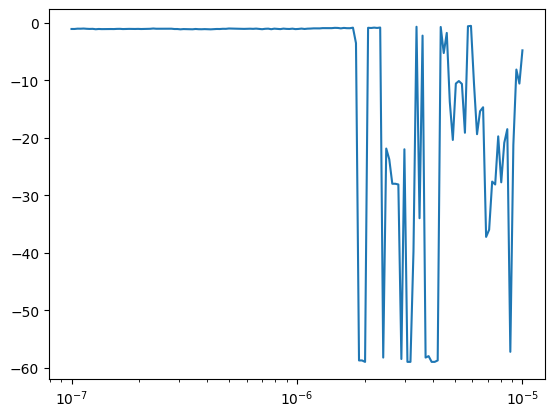

In [30]:
from matplotlib import pyplot as plt   

plt.plot(thresholds, ablated_metrics)
plt.xscale("log")

In [24]:
target_metric = (max(ablated_metrics) - min(ablated_metrics)) * 0.95 + min(ablated_metrics)
target_threshold = [threshold for threshold, metric in reversed(list(zip(thresholds, ablated_metrics))) if metric > target_metric][0]

In [25]:
from tqdm.auto import tqdm
import numpy as np

combined_ies = {}
typed_ies = {
    "r": circuitizer.ie_resid,
    "a": circuitizer.ie_attn,
    "t": circuitizer.ie_transcoder,
}

for layer in tqdm(layers):
    for type in typed_ies:
        if layer in typed_ies[type]: 
            ies = typed_ies[type][layer]
            for mask in circuitizer.masks:
                ies_mask = circuitizer.mask_average(ies, mask)
                i = np.nonzero(np.abs(ies_mask) > target_threshold)[0]
                w = ies_mask[i]

                for idx, weight in zip(i.tolist(), w.tolist()):
                    combined_ies[(layer, mask, type, idx)] = weight

                # w, i = jax.lax.top_k(ies_mask, 4)
                # for idx, weight in zip(i.tolist(), w.tolist()):
                #     combined_ies[(layer, mask, type, idx)] = weight

  0%|          | 0/11 [00:00<?, ?it/s]

In [26]:
combined_ies = [
    key + (weight,)
    for key, weight in combined_ies.items()
]

In [27]:
typed_ies_error = {
    "er": circuitizer.ie_error_resid,
    "ea": circuitizer.ie_error_attn,
    "et": circuitizer.ie_error_transcoder,
}

for layer in tqdm(layers):
    for type in typed_ies_error:
        if layer in typed_ies_error[type]: 
            ies = typed_ies_error[type][layer]
            for mask in circuitizer.masks:
                ies_mask = circuitizer.mask_average(ies, mask)
                # print(ies_mask.tolist())
                # raise
                combined_ies.append((layer, mask, type, 0, ies_mask.tolist()))

  0%|          | 0/11 [00:00<?, ?it/s]

In [28]:
combined_ies = sorted(combined_ies, key=lambda x: -x[-1])

In [29]:
combined_ies[:100]

[(8, 'prompt', 'ea', 0, 0.18912188708782196),
 (14, 'arrow', 'er', 0, 0.04667269065976143),
 (13, 'arrow', 'er', 0, 0.03711532801389694),
 (12, 'arrow', 'er', 0, 0.03687593713402748),
 (11, 'arrow', 'er', 0, 0.028419092297554016),
 (11, 'output', 'er', 0, 0.016914959996938705),
 (11, 'input', 'er', 0, 0.013501716777682304),
 (12, 'input', 'er', 0, 0.013418298214673996),
 (10, 'input', 'er', 0, 0.013065731152892113),
 (10, 'arrow', 'er', 0, 0.012834489345550537),
 (16, 'arrow', 'er', 0, 0.011272262781858444),
 (9, 'input', 'er', 0, 0.010690001770853996),
 (10, 'output', 'r', 31539, 0.009122243151068687),
 (11, 'output', 'r', 5971, 0.008917017839848995),
 (9, 'output', 'r', 28491, 0.008589409291744232),
 (15, 'arrow', 'er', 0, 0.008407769724726677),
 (12, 'output', 'er', 0, 0.008034736849367619),
 (12, 'arrow', 'r', 22136, 0.007973853498697281),
 (11, 'arrow', 'a', 4080, 0.007461613975465298),
 (10, 'output', 'r', 24942, 0.007294937968254089),
 (7, 'output', 'er', 0, 0.007218386046588421),
 (8, 'output', 'et', 0, 0.0069750165566802025),
 (9, 'arrow', 'er', 0, 0.006920747458934784),
 (11, 'arrow', 'et', 0, 0.006815570406615734),
 (14, 'arrow', 'r', 27659, 0.00668629165738821),
 (15, 'arrow', 'r', 14531, 0.006228180136531591),
 (10, 'output', 'er', 0, 0.006211680360138416),
 (12, 'arrow', 'r', 11618, 0.006146292667835951),
 (16, 'arrow', 'r', 19087, 0.006068526767194271),
 (9, 'output', 't', 3442, 0.006003871560096741),
 (16, 'arrow', 'r', 5445, 0.005795613396912813),
 (10, 'output', 'r', 20636, 0.0056126001290977),
 (15, 'arrow', 'et', 0, 0.005584307946264744),
 (9, 'output', 'r', 16425, 0.005500805098563433),
 (14, 'arrow', 'r', 31950, 0.00531836086884141),
 (11, 'prompt', 'er', 0, 0.0052214935421943665),
 (15, 'arrow', 'r', 6663, 0.005219798069447279),
 (10, 'output', 'r', 29472, 0.005133264698088169),
 (13, 'arrow', 'r', 22840, 0.005043341312557459),
 (6, 'output', 'r', 19892, 0.004885741509497166),
 (13, 'arrow', 't', 10580, 0.004870689939707518),
 (15, 'arrow', 'r', 13830, 0.0047426288947463036),
 (6, 'output', 'er', 0, 0.004673415794968605),
 (9, 'output', 'r', 32424, 0.004671826492995024),
 (8, 'prompt', 'r', 21338, 0.004556332714855671),
 (16, 'arrow', 'r', 25826, 0.00453529879450798),
 (11, 'arrow', 'r', 19051, 0.004533370491117239),
 (14, 'arrow', 'r', 7157, 0.004460714291781187),
 (12, 'arrow', 'et', 0, 0.004409285727888346),
 (15, 'arrow', 'r', 26928, 0.004370299633592367),
 (13, 'arrow', 'et', 0, 0.004322022665292025),
 (8, 'output', 'r', 21402, 0.004247972276061773),
 (14, 'arrow', 'r', 29232, 0.004202493466436863),
 (14, 'arrow', 'et', 0, 0.004192355088889599),
 (14, 'arrow', 'r', 10111, 0.004162600263953209),
 (13, 'arrow', 'r', 1069, 0.004151948727667332),
 (7, 'arrow', 'er', 0, 0.004125028848648071),
 (12, 'arrow', 'r', 18840, 0.004103373270481825),
 (11, 'arrow', 't', 28850, 0.003953803796321154),
 (15, 'arrow', 'r', 25945, 0.0039483532309532166),
 (7, 'prompt', 't', 25687, 0.003773904638364911),
 (16, 'arrow', 'r', 16396, 0.0037243126425892115),
 (6, 'input', 'r', 6060, 0.0036839605309069157),
 (7, 'input', 'r', 22736, 0.0036783970426768064),
 (12, 'arrow', 'ea', 0, 0.003662863513454795),
 (14, 'arrow', 'r', 24868, 0.0036473609507083893),
 (15, 'arrow', 'ea', 0, 0.0036249225959181786),
 (13, 'arrow', 'r', 16099, 0.0036046700552105904),
 (16, 'arrow', 'r', 16628, 0.003596897004172206),
 (12, 'input', 'r', 5596, 0.0035651330836117268),
 (15, 'arrow', 'r', 18849, 0.0035538841038942337),
 (9, 'prompt', 'r', 29188, 0.0035487068817019463),
 (7, 'output', 'r', 25335, 0.003503157990053296),
 (15, 'arrow', 'r', 7118, 0.003494291566312313),
 (8, 'arrow', 'ea', 0, 0.003493135329335928),
 (6, 'prompt', 'er', 0, 0.003485039807856083),
 (12, 'arrow', 'r', 6780, 0.0034501508343964815),
 (9, 'arrow', 'r', 19243, 0.0034348652698099613),
 (10, 'output', 'r', 12895, 0.003410435514524579),
 (6, 'arrow', 'er', 0, 0.0033588914666324854),
 (16, 'newline', 'er', 0, 0.0033419914543628693),
 (9, 'arrow', 'ea', 0, 0.0033310435246676207)

In [19]:
important_feats_masks = {}
for mask in circuitizer.masks:
    important_feats_masks[mask] = [
        (type, layer, feat) for layer, f_mask, type, feat, _ in combined_ies if f_mask == mask
        ]

In [20]:
from collections import defaultdict
flat_feats = defaultdict(list)
for k, v in important_feats_masks.items():
    for type, layer, feat in v:
        flat_feats[(k, type, layer)].append(feat)

In [36]:
from tqdm.auto import trange
import jax.numpy as jnp
graph = []

batch_size = 16
k = 32
for type, features in tqdm(sorted(flat_feats.items(), key=lambda x: (-x[0][-1], x[0][-2], x[0][-3]))):
    mask, feature_type, layer = type
    mask = jnp.array(list(circuitizer.masks.keys()).index(mask))
    for batch in trange(0, len(features), batch_size, postfix=str(type)):
        batch_features = features[batch:batch+batch_size]
        orig_length = len(batch_features)
        batch_features = batch_features + [0] * (batch_size - len(batch_features))
        feature_effectss = jax.vmap(lambda x: circuitizer.compute_feature_effects(feature_type, layer, x, mask, layer_window=1))(jnp.asarray(batch_features))
        # feature_effectss = circuitizer.compute_feature_effects(feature_type, layer, batch_features, mask, layer_window=1)
        top_effects = defaultdict(list)
        for key, featuress in feature_effectss.items():
            for elem, feature_effects in enumerate(featuress):
                if elem >= orig_length:
                    continue
                if feature_effects.ndim == 0:
                    top_effects[elem].append((float(feature_effects), key, 0))
                    continue
                effects, indices = jax.lax.top_k(jnp.abs(feature_effects), k)
                for i, e in zip(indices.tolist(), effects.tolist()):
                    top_effects[elem].append((e, key, i))
        for elem, effects in top_effects.items():
            effects.sort(reverse=True)
            edges = effects[:k]
            graph.extend([(weight,  key + (upstream_feature,), (type[1], type[2], type[0], batch_features[elem],) ) for weight, key, upstream_feature in edges])
        
        # # edges = circuitizer.compute_edges(*feature, mask, layer_window=1)
        # graph.extend([(weight, feature, downstream_feature) for weight, _, downstream_feature in edges])
    
        # for feature in tqdm(batch_features):
        #     feature_effects = circuitizer.compute_feature_effects(feature_type, layer, feature, mask, layer_window=1)
        #     top_effects = []
        #     for key, features in feature_effects.items():
        #         if features.ndim == 0:
        #             top_effects.append((float(features), key, 0))
        #             continue
        #         effects, indices = jax.lax.top_k(jnp.abs(features), k)
        #         for i, e in zip(indices.tolist(), effects.tolist()):
        #             top_effects.append((e, key, i))
        #     top_effects.sort(reverse=True)
        #     edges = top_effects[:k]
            
        #     # edges = circuitizer.compute_edges(*feature, mask, layer_window=1)
        #     graph.extend([(weight, feature, downstream_feature) for weight, _, downstream_feature in edges])



# for mask, features in tqdm(important_feats_masks.items()):
#     for batch in trange(0, len(features), batch_size):
#         batch_features = features[batch:batch+batch_size]
        
        
#         for feature in tqdm(batch_features):
#             # edges = circuitizer.compute_edges(*feature, mask, layer_window=1)
#             graph.extend([(weight, feature, downstream_feature) for weight, _, downstream_feature in edges])


#     # for downstream_feature in tqdm(features):
#     #     edges = compute_edges(downstream_feature, mask, layer_window=1)
#     #     graph.extend([(weight, upstream_feature_key + (upstream_feature,), downstream_feature[:2] + (mask,) + downstream_feature[2:])
#     #                   for weight, upstream_feature_key, upstream_feature in edges])

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s, ('arrow', 'a', 16)]

dict_keys([('er', 16, 'arrow'), ('er', 16, 'input'), ('er', 16, 'newline'), ('er', 16, 'output'), ('er', 16, 'prompt'), ('r', 16, 'arrow'), ('r', 16, 'input'), ('r', 16, 'newline'), ('r', 16, 'output'), ('r', 16, 'prompt')]) [26950, 25539, 1085, 14538, 19232, 7123, 20911, 12264, 12539, 12413, 32120, 26574, 23636, 23114, 178, 12793]
('er', 16, 'arrow') (16,)
('er', 16, 'input') (16,)
('er', 16, 'newline') (16,)
('er', 16, 'output') (16,)
('er', 16, 'prompt') (16,)
('r', 16, 'arrow') (16, 32768)
('r', 16, 'input') (16, 32768)
('r', 16, 'newline') (16, 32768)
('r', 16, 'output') (16, 32768)
('r', 16, 'prompt') (16, 32768)
[(6.0595695686060935e-05, ('er', 16, 'input', 0), ('a', 16, 'arrow', 26950)), (4.51656014774926e-05, ('r', 16, 'prompt', 5241), ('a', 16, 'arrow', 26950)), (3.955366264563054e-05, ('r', 16, 'arrow', 29818), ('a', 16, 'arrow', 26950)), (3.92732436012011e-05, ('r', 16, 'arrow', 24991), ('a', 16, 'arrow', 26950)), (3.684913463075645e-05, ('er', 16, 'prompt', 0), ('a', 16, '

ZeroDivisionError: division by zero

In [37]:
combined_ies[0]

(11, 'arrow', 'a', 23594, 0.41276583075523376)

In [ ]:
sorted_graph = sorted(graph, reverse=True, key=lambda x: x[0])